In [1]:
import zipfile
zip_file = zipfile.ZipFile('/content/model_test.zip')
zip_file.extractall('/content/')

In [2]:
import pandas as pd
df=pd.read_csv('model_test.csv')
img_list = ['/content/model_test/' + filename for filename in df['filename']]
label = [0 if lbl == 'happy' else 1 for lbl in df['label']]

In [ ]:
import torch
def load_checkpoint(load_path, model,device):
    checkpoint = torch.load(load_path,map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_accuracies = checkpoint.get('val_accuracies', [])

    return checkpoint['epoch'], train_losses, val_losses, train_accuracies, val_accuracies

### test_img(model_weight, img_list): 학습한 모델로 test set 평가
- de, eff, res에 따라 각 모델 구조에 맞는 model weight load
- predictions: 예측된 label 반환
- probabilities: label의 확률 반환

In [ ]:
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

class CustomDataset(Dataset):
    def __init__(self, img_paths, labels=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return image, label
        else:
            return image

def test_img(model_weight,img_list):
  if "de" in model_weight:
    model = models.densenet121(pretrained=True)

    for param in model.parameters():
      param.requires_grad = False
    for param in model.features.denseblock4.parameters():
      param.requires_grad = True

    num_classes = 1
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    for param in model.classifier.parameters():
      param.requires_grad = True

  elif "eff" in model_weight:
    model = models.efficientnet_b0(pretrained=True)

    for param in model.parameters():
      param.requires_grad = False

    for param in model.features[5:].parameters():
      param.requires_grad = True
    num_classes = 1
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    for param in model.classifier.parameters():
      param.requires_grad = True

  elif "res" in model_weight:
    if "18" in model_weight:
      model = models.resnet18(pretrained=True)
    elif "34" in model_weight:
      model = models.resnet34(pretrained=True)

    for param in model.parameters():
      param.requires_grad = False
    for param in model.layer4.parameters():
      param.requires_grad = True
    num_classes = 1
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    for param in model.fc.parameters():
      param.requires_grad = True

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  start_epoch, train_losses, val_losses, train_accuracies, val_accuracies = load_checkpoint(model_weight, model, device)

  model.to(device)
  model.eval()

  test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
  ])

  test_dataset = CustomDataset(img_list, labels=None, transform=test_transform)
  test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

  predictions=[]
  probabilities = []

  with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images).squeeze()
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).long()
        predictions.extend(predicted.cpu().tolist())
        probabilities.extend(probs.cpu().tolist())

  return predictions,probabilities

### densenet - sgd

In [7]:
pred_de_sgd_b,prob_de_sgd_b=test_img("de_sgd_b.pth",img_list)

<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path,map_location=device)


### 성능 평가

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def calculate_metrics(label, pred):
  ret=[]
  precision = np.round(precision_score(label, pred),4)
  recall = np.round(recall_score(label, pred),4)
  f1 = np.round(f1_score(label, pred),4)

  print(f"denseset_sgd Metrics: Precision: {precision}, Recall: {recall}, F1: {f1}")

  ret.append(precision)
  ret.append(recall)
  ret.append(f1)

  return ret
de_sgd_b_met=calculate_metrics(label,pred_de_sgd_b)

denseset_sgd Metrics: Precision: 0.9417, Recall: 0.9898, F1: 0.9652


### 예측 틀린 이미지 시각화

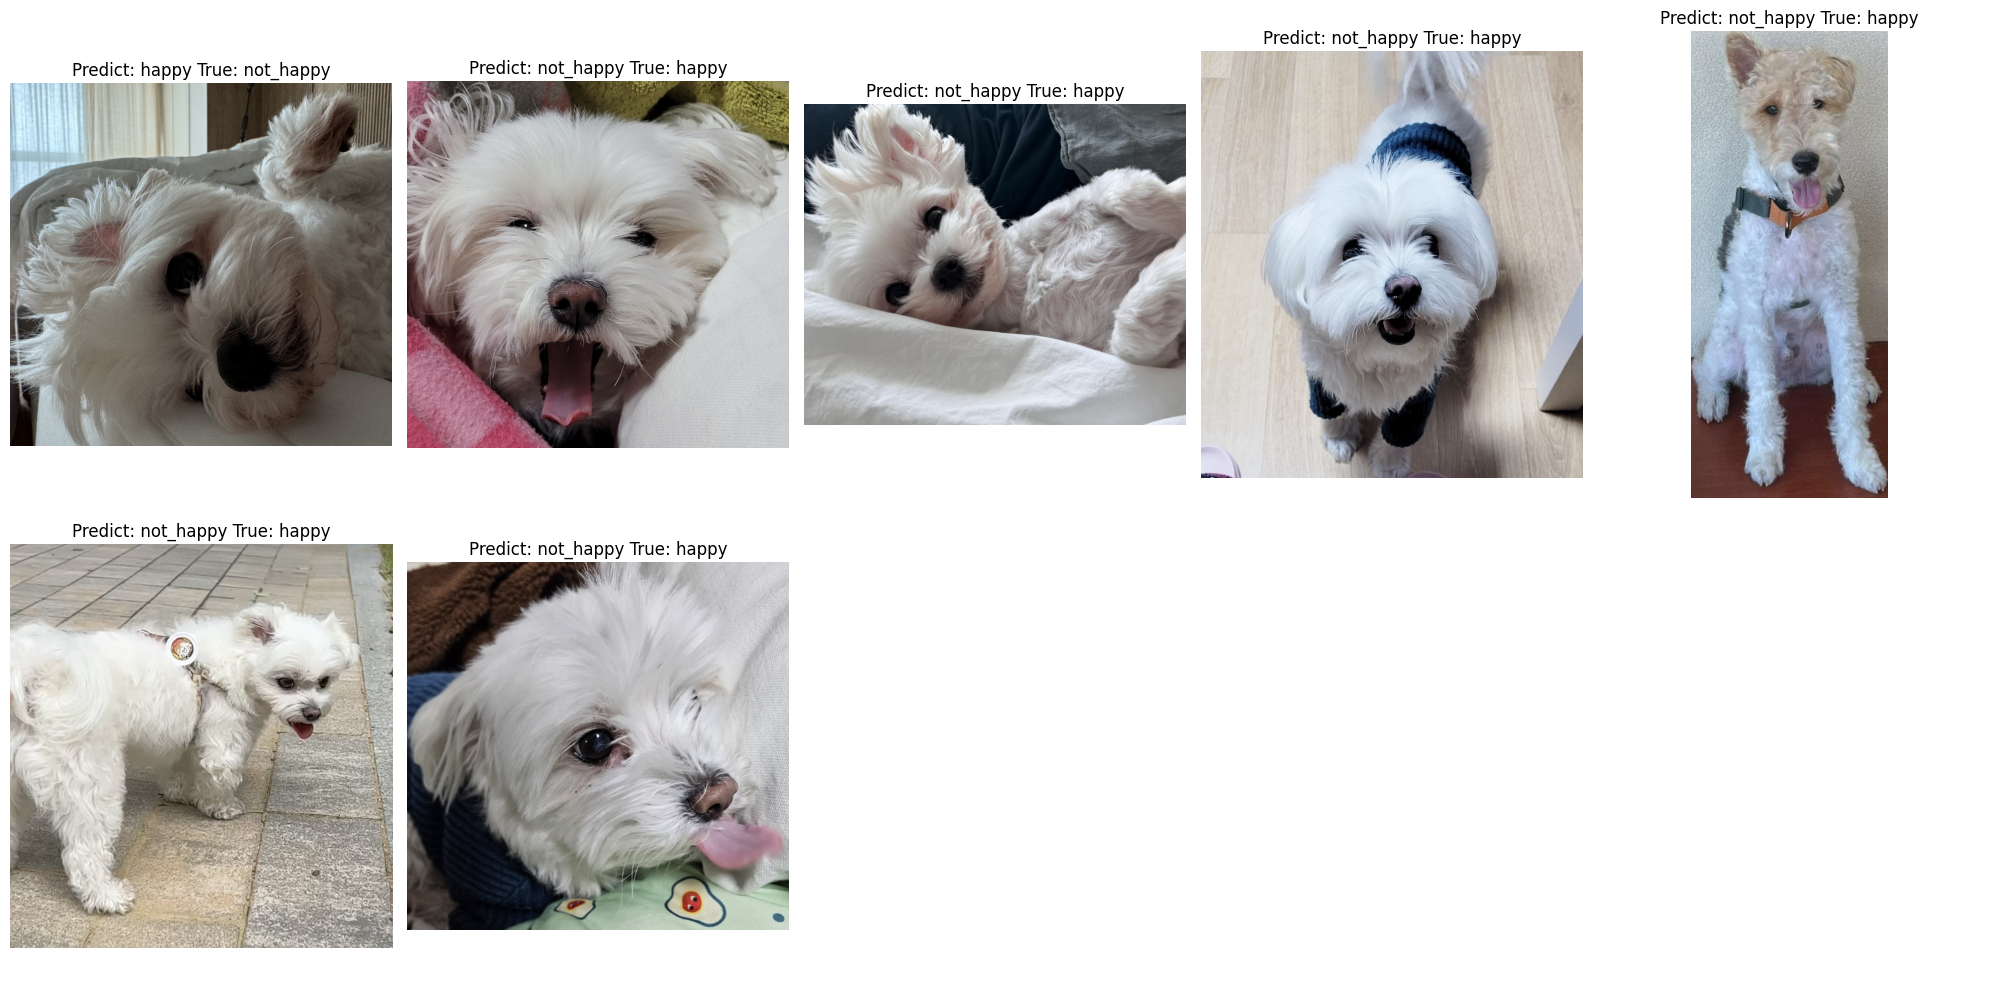

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import os


def show_fpred(label,predict,img_list):
  mismatch_indices = [i for i, (true, pred) in enumerate(zip(label, predict)) if true != pred]
  image_list = [img_list[i] for i in mismatch_indices]
  title_texts = [
    f"Predict: {'happy' if predict[i] == 0 else 'not_happy'} True: {'happy' if label[i] == 0 else 'not_happy'}"
    for i in mismatch_indices
  ]

  num_images = len(image_list)
  rows = (num_images + 4) // 5
  fig, axes = plt.subplots(rows, 5, figsize=(20, rows * 5))

  for idx, (img_path, title) in enumerate(zip(image_list, title_texts)):
    img = Image.open(img_path)
    ax = axes[idx // 5, idx % 5] if rows > 1 else axes[idx % 5]
    ax.imshow(img)
    ax.set_title(title, fontsize=12)
    ax.axis('off')
  for idx in range(len(image_list), rows * 5):
    ax = axes[idx // 5, idx % 5] if rows > 1 else axes[idx % 5]
    ax.axis('off')

  plt.tight_layout()
  plt.show()
  new_image_list = [os.path.basename(path) for path in image_list]
  return new_image_list

mis_de_sgd_b=show_fpred(label, pred_de_sgd_b, img_list)

### densenet - AdamW, ReduLROnPlateau

In [10]:
pred_de_ada_re_b, prob_de_ada_re_b=test_img("de_ada_re_b.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more d

In [11]:
de_ada_re_b_met=calculate_metrics(label,pred_de_ada_re_b)

denseset_sgd Metrics: Precision: 0.9697, Recall: 0.9796, F1: 0.9746


### densenet - AdamW, ReduceLROnPlateau (early stopping)

In [12]:
pred_de_ada_re8_b,prob_de_ada_re8_b=test_img("de_ada_re_b_epoch_8.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more d

In [13]:
de_ada_re8_b_met=calculate_metrics(label,pred_de_ada_re8_b)

denseset_sgd Metrics: Precision: 0.97, Recall: 0.9898, F1: 0.9798


### densenet - sgd, CosineAnnealingLR

In [14]:
pred_de_sgd_cos_b,prob_de_sgd_cos_b=test_img("de_sgd_cos_b.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more d

In [15]:
de_sgd_cos_b_met=calculate_metrics(label,pred_de_sgd_cos_b)

denseset_sgd Metrics: Precision: 0.9604, Recall: 0.9898, F1: 0.9749


### densenent - sgd, CosineAnnealingLR (early stopping)

In [16]:
pred_de_sgd_cos10_b,prob_de_sgd_cos10_b=test_img("de_sgd_cos_b_epoch_10.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more d

In [24]:
de_sgd_cos10_b_met=calculate_metrics(label,pred_de_sgd_cos10_b)

denseset_sgd Metrics: Precision: 0.9515, Recall: 1.0, F1: 0.9751


### densenet - AdamW

In [18]:
pred_de_ada_b,prob_de_ada_b=test_img("de_ada_b.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more d

In [26]:
de_ada_b_met=calculate_metrics(label,pred_de_ada_b)

denseset_sgd Metrics: Precision: 0.9897, Recall: 0.9796, F1: 0.9846


### densenet - AdamW (early stopping)

In [28]:
pred_de_ada7_b,prob_de_ada7_b=test_img("de_ada_b_epoch_7.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more d

In [29]:
de_ada7_b_met=calculate_metrics(label,pred_de_ada7_b)

denseset_sgd Metrics: Precision: 0.9896, Recall: 0.9694, F1: 0.9794


### 데이터프레임으로

In [31]:
data = [
    {"filename": "de_sgd_b_met", "precision": de_sgd_b_met[0], "recall": de_sgd_b_met[1], "f1": de_sgd_b_met[2]},
    {"filename": " de_ada_re_b_met", "precision":  de_ada_re_b_met[0], "recall":  de_ada_re_b_met[1], "f1":  de_ada_re_b_met[2]},
    {"filename": " de_ada_re8_b_met", "precision":  de_ada_re8_b_met[0], "recall":  de_ada_re8_b_met[1], "f1":  de_ada_re8_b_met[2]},
    {"filename": "de_sgd_cos_b_met", "precision": de_sgd_cos_b_met[0], "recall": de_sgd_cos_b_met[1], "f1": de_sgd_cos_b_met[2]},
    {"filename": " de_sgd_cos10_b_met", "precision":  de_sgd_cos10_b_met[0], "recall":  de_sgd_cos10_b_met[1], "f1":  de_sgd_cos10_b_met[2]},
    {"filename": "de_ada_b_met ", "precision": de_ada_b_met [0], "recall": de_ada_b_met [1], "f1": de_ada_b_met [2]},
    {"filename": " de_ada7_b_met", "precision":  de_ada7_b_met[0], "recall":  de_ada7_b_met[1], "f1":  de_ada7_b_met[2]}
]

df = pd.DataFrame(data)

In [32]:
df.to_csv('densenet_metrics_new.csv', index=False)

In [37]:
img_list = [os.path.basename(path) for path in img_list]

df_prob = pd.DataFrame({
    'img_list':pd.Series(img_list),
    'prob_de_sgd_b': pd.Series(prob_de_sgd_b),
    'prob_de_ada_re_b': pd.Series(prob_de_ada_re_b),
    'prob_de_ada_re8_b': pd.Series(prob_de_ada_re8_b),
    'prob_de_sgd_cos_b': pd.Series(prob_de_sgd_cos_b),
    'prob_de_sgd_cos10_b': pd.Series(prob_de_sgd_cos10_b),
    'prob_de_ada_b': pd.Series(prob_de_ada_b),
    'prob_de_ada7_b': pd.Series(prob_de_ada7_b)
})


In [38]:
df_prob

,img_list,prob_de_sgd_b,prob_de_ada_re_b,prob_de_ada_re8_b,prob_de_sgd_cos_b,prob_de_sgd_cos10_b,prob_de_ada_b,prob_de_ada7_b
0,172.jpg,0.978570,9.412828e-01,9.602340e-01,0.991550,0.973050,9.662514e-01,0.863469
1,190.jpg,0.951871,7.460767e-01,7.440819e-01,0.848633,0.989341,7.895899e-01,0.825883
2,60.jpg,0.000282,6.999893e-04,3.545355e-03,0.001245,0.000060,3.400879e-04,0.003843
3,229.jpg,0.993640,9.875794e-01,9.924291e-01,0.986790,0.999485,9.494333e-01,0.974549
4,183.jpg,0.914387,8.642842e-01,9.414758e-01,0.730439,0.964878,9.840884e-01,0.831023
...,...,...,...,...,...,...,...,...
165,86.jpg,0.103160,7.898577e-03,4.844555e-02,0.085563,0.025238,2.502110e-03,0.018569
166,130.jpg,0.952401,7.334811e-01,9.715680e-01,0.973620,0.996328,9.617468e-01,0.920728
167,200.jpg,0.795818,6.038223e-01,8.473738e-01,0.954502,0.937704,8.542225e-01,0.707561
168,59.jpg,0.000007,1.200657e-07,5.567198e-07,0.000092,0.000008,2.054130e-07,0.000018


In [39]:
df_prob.to_csv('densenet_probability_new.csv', index=False)